In [62]:
####### Imports #######
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.feature import hog

import os



import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
class Dict(dict):
    """Container object exposing keys as attributes.
    Dict objects are sometimes used as an output for functions and methods.
    They extend dictionaries by enabling values to be accessed by key,
    `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
    Examples
    --------
    >>> from sklearn.utils import Bunch
    >>> b = Dict(a=1, b=2)
    >>> b['b']
    2
    >>> b.b
    2
    >>> b.a = 3
    >>> b['a']
    3
    >>> b.c = 6
    >>> b['c']
    6
    """

    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __dir__(self):
        return self.keys()

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setstate__(self, state):
        # Bunch pickles generated with scikit-learn 0.16.* have an non
        # empty __dict__. This causes a surprising behaviour when
        # loading these pickles scikit-learn 0.17: reading bunch.key
        # uses __dict__ but assigning to bunch.key use __setattr__ and
        # only changes bunch['key']. More details can be found at:
        # https://github.com/scikit-learn/scikit-learn/issues/6196.
        # Overriding __setstate__ to be a noop has the effect of
        # ignoring the pickled __dict__
        pass

In [3]:
####### Code #######

def createDict(folder_path,size):
    """Create a DataFrame from a folder containing images
    
    Args:
        fodler_path (str): The folder location of the dataset

    Returns:
        df (DataFrame): The dataset in a pandas DataFrame format
    """
    datas = []
    targets = []
    
    for i in os.listdir(folder_path):
        for j in os.listdir(folder_path + "/" + i):
            datas.append(Image.open(folder_path + "/" + i + "/" + j).resize((size[0],size[1])))
            targets.append(i)
    return Dict(data = datas, target = targets)

In [48]:
dico = createDict("./fruits",(32,32))

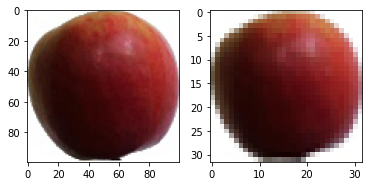

In [49]:
fig, figs = plt.subplots(1,2)
figs[0].imshow(Image.open("./fruits/Apple Crimson Snow/0_100.jpg"))
figs[1].imshow(dico.data[0])

In [88]:
# print(dico)
datas = dico.data
targets = dico.target
classes = list(set(targets))
print(classes)

trans = transforms.ToTensor()

def targetToTensorIndex(classe):
    return torch.tensor([[classes.index(classe)]])
    
def imgToTensor(img):
    return trans(img)
    
targets = list(map(targetToTensorIndex, targets))
datas = list(map(imgToTensor, datas))
print(targets[0])
# print(type(targets[0]))
print(datas[0])
# print(imgToTensor(datas[0]))

['Watermelon', 'Apple Red', 'Banana', 'Apple Crimson Snow', 'Apple Golden']
tensor([[3]])
tensor([[[1.0000, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         ...,
         [0.9961, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
         [1.0000, 1.0000, 0.9961,

In [90]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
#         self.conv2 = nn.Conv2(in_channels=out_channels, out_channels=out_channels, kernel_size=3),#, padding=1, stride=1, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

############################################################################


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

############################################################################

running_loss = 0.0

# get the inputs; data is a list of [inputs, labels]
inputs, labels = datas,targets
# print("inputs :", inputs)
# print("\n")
# print("labels :", labels)

# zero the parameter gradients
optimizer.zero_grad()

# forward + backward + optimize
outputs = net(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

# print statistics
running_loss += loss.item()


print('loss: %.3f' % (running_loss))
running_loss = 0.0

print('Finished Training')

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


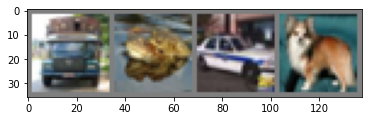

truck  frog   car   dog


In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [79]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(type(inputs))
    print(type(labels))
    print(labels)
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([5, 4, 5, 4])
